# Data Analysis

In [1]:
#from gensim import models
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### Read in data
Here, I read in two files:
* all the google assistent logs provided to me by a friend -> voice_inputs
* a file containing the inputs I classified as private -> private_convos

In [3]:
voice_inputs = list()
flag = False
with open("AssistantVerlauf_Valentin.csv", encoding="utf-8") as f:
    for line in f:
        lline = line.split()
        if flag:
            if lline[-1] == "gesagt":
                # exclude the "gesagt" at the end of each log
                line = line.lower()
                #print(line)
                voice_inputs.append(line[:-8])
        if line == "Google Assistant\n":
            flag = True
        else:
            flag = False

private_convos = list()
with open("google_private_convos.txt", encoding="utf-8") as g:
    for line in g:
        line = line.strip()
        line = line.lower()
        private_convos.append(line)
len(voice_inputs)

590

### Create embeddings
Embeddings are created with the SentenceTransformer (add citation)

In [4]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(voice_inputs)

### Create tf-idf scores

In [ ]:
texts = [[word for word in document.lower().split()] for document in voice_inputs]
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]
from gensim import corpora

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)
dictionary.token2id
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
from gensim import models

# train the model
tfidf = models.TfidfModel(bow_corpus)

# transform the "system minors" string
words = "navigiere minuten".lower().split()
print(tfidf[dictionary.doc2bow(words)])
from gensim import similarities

index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=184)
index

### Create dataframe
The dataframe includes all input sentences (326) as well as their embeddings (vectors of length 384).

In [5]:
data = dict()
for sentence, embedding in zip(voice_inputs, embeddings):
    data[sentence] = embedding

sentences = list(data.keys())
df = pd.DataFrame(data)
df = df.transpose()
print (df)

                                                         0         1    \
spiele nachrichten                                 -0.063686  0.049910   
descendants                                        -0.039261 -0.001042   
stell einen timer auf 10 minuten                   -0.074005  0.070900   
navigiere zur lessingstraße in saarbrücken          0.021619  0.170627   
stelle einen timer auf 10 minuten                  -0.058300  0.089796   
...                                                      ...       ...   
woher kommt der begriff anschwärzen                -0.090010  0.055295   
wo liegt der wert von ea                           -0.006836  0.132749   
stelle einen timer bis 25 minuten                  -0.035846  0.096663   
richte mir eine erinnerung ein für den 26.10 20... -0.058103  0.042296   
gibt es cordhemden                                 -0.049189  0.027560   

                                                         2         3    \
spiele nachrichten                   

### Standardize Data
Standardizing the Data for the PCA

In [6]:
x = StandardScaler().fit_transform(df)
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.517818,-0.649692,0.318912,-0.991234,-0.508936,0.599497,-0.092481,-1.203140,-0.487079,0.087002,...,-0.308977,-0.644471,0.075362,-0.605676,0.740662,-0.390662,0.732909,0.172623,-0.104978,1.229761
1,0.084454,-1.811735,-0.721727,-0.344017,-0.399698,-1.555813,-1.271558,-1.210927,0.308024,0.852693,...,0.119418,-2.880031,-0.369971,1.348575,1.106051,2.184058,3.157123,0.800319,1.299146,0.342946
2,-0.772264,-0.170986,-0.210805,-0.591017,-0.301542,1.167042,0.172339,0.985133,1.117517,-2.167140,...,-0.185002,0.510899,1.090756,-1.489027,-0.955040,1.708333,-1.208839,2.295907,0.330169,0.450577
3,1.585581,2.103449,0.352525,-0.356557,-0.119150,0.859673,-1.769308,-0.394411,-1.044212,-0.459479,...,-2.103694,-0.156650,0.400745,0.330627,-0.096174,-0.099827,0.294596,-1.328622,-0.937501,1.324316
4,-0.384998,0.259964,-0.648774,-0.643933,-0.574273,1.057892,-0.077913,0.796355,1.009130,-1.922245,...,-0.048678,0.504400,0.799401,-1.425614,-0.766560,1.512565,-1.270997,2.107906,0.119461,0.075786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,-1.166889,-0.526866,0.418844,1.270163,-0.141154,-0.252978,-0.195777,1.122578,-0.006395,0.718295,...,-0.743948,-1.245714,1.097074,0.575669,0.277846,-2.180182,0.422432,-0.270159,0.795745,0.947750
318,0.883968,1.239577,-0.772545,-0.515183,1.130067,-0.516494,1.191158,-0.641871,1.869576,0.634043,...,0.769116,-0.410194,-0.886167,-1.007576,0.698000,-1.942584,-0.566766,-1.477060,1.730780,0.966279
319,0.168651,0.416584,-0.778629,-1.663119,-1.569805,0.021569,0.084679,0.518118,1.348533,-0.945126,...,0.397622,0.932567,0.424693,-1.341669,0.147855,1.051680,-1.252911,0.574934,-0.222113,-0.344015
320,-0.380141,-0.823332,0.386634,1.613054,0.141893,0.726970,-0.892619,0.599738,0.081240,-0.737529,...,-0.534466,1.602536,-1.330220,-0.647493,0.575537,0.374827,0.675690,0.327655,-1.853228,0.795514


### Dimensionality Reduction
Performing the PCA-Algorithm, reducing the embeddings dimensions from 384 to 2 in order to gain a nice visual representation of the inputs.

In [7]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
#principalDf
principalDf.index = sentences
principalDf

,principal component 1,principal component 2
spiele nachrichten,-3.750953,-6.130625
descendants,-3.499496,-0.629433
stell einen timer auf 10 minuten,15.536218,-0.612225
navigiere zur lessingstraße in saarbrücken,-2.846065,-9.651804
stelle einen timer auf 10 minuten,15.829771,-1.676221
...,...,...
woher kommt der begriff anschwärzen,-2.802301,-2.068233
wo liegt der wert von ea,-0.244325,5.008826
stelle einen timer bis 25 minuten,14.555099,-2.448772
richte mir eine erinnerung ein für den 26.10 20 uhr,2.157587,3.598815


### Adding manual annotation
Adding the manual annotations to the dataframe

In [8]:
private = list()
for sen in sentences:
    if sen in private_convos:
        private.append(True)
    else:
        private.append(False)
#finalDf = pd.concat([principalDf, pd.DataFrame(private), axis = 1)
finalDf = principalDf
finalDf['private'] = private
finalDf

,principal component 1,principal component 2,private
spiele nachrichten,-3.750953,-6.130625,False
descendants,-3.499496,-0.629433,False
stell einen timer auf 10 minuten,15.536218,-0.612225,False
navigiere zur lessingstraße in saarbrücken,-2.846065,-9.651804,False
stelle einen timer auf 10 minuten,15.829771,-1.676221,False
...,...,...,...
woher kommt der begriff anschwärzen,-2.802301,-2.068233,False
wo liegt der wert von ea,-0.244325,5.008826,False
stelle einen timer bis 25 minuten,14.555099,-2.448772,False
richte mir eine erinnerung ein für den 26.10 20 uhr,2.157587,3.598815,False


### Plot PCA

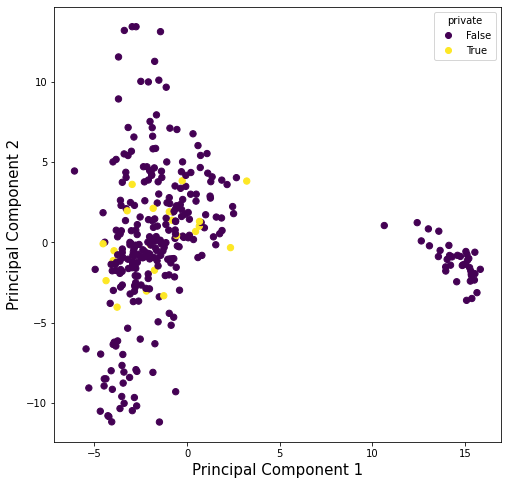

In [31]:
fig = plt.figure(figsize = (8,8))
scatter = plt.scatter(finalDf["principal component 1"], finalDf["principal component 2"], c = finalDf["private"], s = 40)
#ax.set_xlabel("Principal Component 1", fontsize = 15)
plt.xlabel("Principal Component 1", fontsize = 15)
#ax.set_ylabel("Principal Component 2", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
#plt.legend(finalDf["private"])
plt.legend(handles=scatter.legend_elements()[0], 
           labels=[False, True],
           title="private")
fig.savefig('PCAplot.jpg', bbox_inches='tight', dpi=150)
#plt.show()

### K-Means Clustering
Clustering the reduced dimensions with k-means

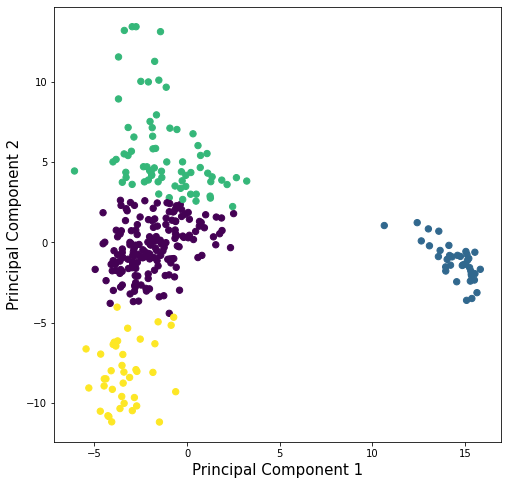

In [41]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(principalDf)
y_kmeans = kmeans.predict(principalDf)

fig = plt.figure(figsize = (8,8))
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
scatter2 = plt.scatter(finalDf["principal component 1"], finalDf["principal component 2"], c=y_kmeans, s=40, cmap='viridis')
#plt.legend(y_kmeans)
# plt.legend(handles=scatter2.legend_elements()[0], 
        #    labels=["navigiere","was/wie/wo","kurz/random","timer"],
        #    title="clusters")
fig.savefig('PCAplot2.jpg', bbox_inches='tight', dpi=150)

In [39]:
for i in zip(sentences, y_kmeans, private):
    #eval.append((i[1], i[2]))
    if i[1] == 3:
        print(i)

('was ist ein juppi', 3, False)
('wie viel uhr ist es', 3, False)
('was ist ein box set', 3, False)
('was für ein lied ist das', 3, False)
('was ist pittoresk', 3, False)
('was ist ein eierloch', 3, False)
('richte mir eine erinnerung ein für 24.1', 3, False)
('was läuft da für ein lied', 3, False)
('für ein lied ist das', 3, False)
('welches lied läuft da', 3, False)
('richte erinnerung ein für donnerstag 8 uhr', 3, False)
('was ist ein überbau', 3, False)
('wie macht ein waschbär', 3, False)
('wie macht ein faultier', 3, False)
('wie macht ein fisch', 3, False)
('kannst du mir einen witz erzählen', 3, False)
('kannst du mir noch ein lied singen', 3, False)
('singst du mir noch ein lied', 3, False)
('bringst du mir noch ein lied', 3, False)
('singst du mir ein lied', 3, False)
('liest du nicht gerne', 3, False)
('was ist ein kongenialer partner', 3, False)
('richte mir eine erinnerung ein für 12 uhr', 3, False)
('was ist das für ein lied', 3, False)
('was was ist das für ein lied', 3,

### Clustering the full dimensional embeddings

In [42]:
kmeans2 = KMeans(n_clusters=4)
kmeans2.fit(df)
y_kmeans2 = kmeans2.predict(df)


In [46]:
eval = list()
for i in zip(sentences, y_kmeans, private):
    eval.append((i[1], i[2]))
    if i[1] == 0:
    #if i[2] == True:
        print(i)

('descendants', 0, False)
('wie spät haben wir es in eigentlich', 0, False)
('v200', 0, False)
('wie viel uhr haben wir dann', 0, False)
('senden', 0, False)
('nach welchem lied habe ich zuletzt gesucht', 0, False)
('was habe ich zuletzt gesucht', 0, False)
('zeige den verlauf an', 0, False)
('navigiere zur europaallee', 0, False)
('wo gibt es die nächsten gebratene nudeln', 0, False)
('wie viel uhr ist es eigentlich', 0, False)
('richte eine erinnerung ein für null uhr dreißig uhr marc schreiben', 0, False)
('papaya bestellen', 0, False)
('wo liegt der lago maggiore', 0, False)
('wo ist sierra leone', 0, False)
('wie macht eine luisa', 0, False)
('wie macht eine schmerle', 0, False)
('beleidige mich', 0, False)
('erzähl mir einen reim', 0, False)
('erzähl mir einen zungenbrecher', 0, False)
('noch einen', 0, False)
('bist du les paul', 0, False)
('was ist bischmisheim', 0, False)
('was ist sabriye', 0, False)
('kino altona', 0, False)
('was heißt kongenial', 0, False)
('ok google was 

In [45]:
tp = sum([1 for i,j in eval if j and i == 0])
fn = sum([1 for i,j in eval if j and i != 0])
fp = sum([1 for i,j in eval if j == False and i == 0])
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fscore = (2 * precision * recall) / (precision + recall)
print(precision, recall, fscore)

0.09826589595375723 0.8095238095238095 0.1752577319587629


## Results
Unsupervised learning algorithms like PCA and K-means clustering do not help with to distinguish the private data from the rest.